In [1]:
import pickle
import os
import sys
#sys.path.append(os.path.abspath('efficientnet-master/efficientnet-master'))
from efficientnet.keras import EfficientNetB5

Using TensorFlow backend.


In [2]:
import cv2
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
#from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import os
import sys
import keras
from keras.models import load_model
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import elu
from keras.optimizers import Adam
from keras.models import Sequential
from keras.engine import Layer, InputSpec
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

In [4]:
KAGGLE_DIR = 'APTOS/'
TRAIN_DF_PATH = KAGGLE_DIR + "train.csv"
TEST_DF_PATH = KAGGLE_DIR + 'test.csv'
TRAIN_IMG_PATH = KAGGLE_DIR + "train_images/"
TEST_IMG_PATH = KAGGLE_DIR + 'test_images/'
SAVED_MODEL_NAME = 'effnet_modelB5.h5'
seed = 1234
rn.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
t_start = time.time()

In [5]:
print('\n# Files and file sizes')
for file in os.listdir(KAGGLE_DIR): 
    print('{}| {} MB'.format(file.ljust(30), 
                             str(round(os.path.getsize(KAGGLE_DIR + file) / 1000000, 2))))


# Files and file sizes
test.csv                      | 0.0 MB
test1.csv                     | 0.03 MB
test_images                   | 0.0 MB
test_images1                  | 1.05 MB
test_images1.zip              | 1612.79 MB
train.csv                     | 0.05 MB
train_images                  | 1.84 MB
train_images.zip              | 8602.29 MB


In [6]:
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DF_PATH)
train_df['id_code'] = train_df['id_code'] + ".png"
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())
print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DF_PATH)
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())

Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 2


,id_code
0,0a2b5e1a0be8.png
1,001639a390f0.png


In [7]:
IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3

In [8]:
def get_preds_and_labels(model, generator):
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [9]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(SAVED_MODEL_NAME)
        return

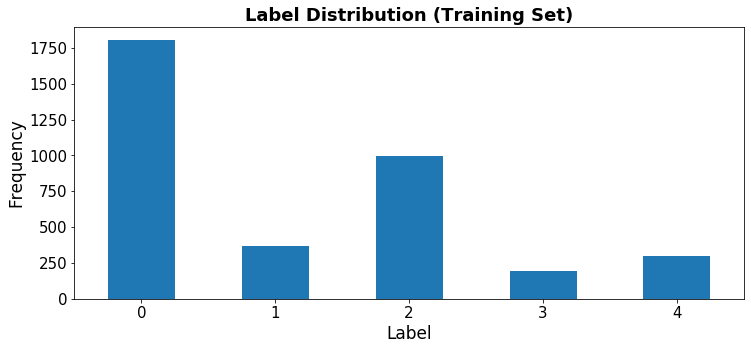

In [10]:
train_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

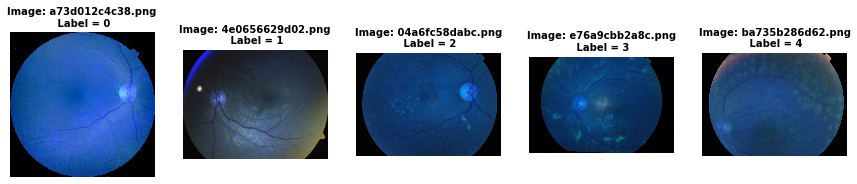

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = cv2.imread(f"{TRAIN_IMG_PATH}{image_name}")
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [12]:
def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim== 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted(image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

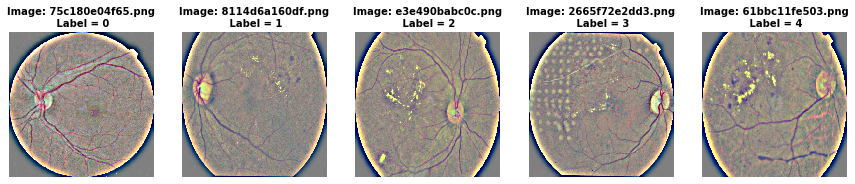

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = preprocess_image(cv2.imread(f"{TRAIN_IMG_PATH}{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [14]:
y_labels = train_df['diagnosis'].values

In [15]:
BATCH_SIZE = 4
train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.15,
                                   preprocessing_function=preprocess_image, 
                                   rescale=1 / 128.)
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='id_code', 
                                                    y_col='diagnosis',
                                                    directory = TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other', 
                                                    subset='training')

val_generator = train_datagen.flow_from_dataframe(train_df, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis',
                                                  directory = TRAIN_IMG_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other',
                                                  subset='validation')

Found 3113 validated image filenames.
Found 549 validated image filenames.


In [16]:
class RAdam(keras.optimizers.Optimizer):
    

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            decay_steps = self.total_steps - warmup_steps
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                lr * (1.0 - K.minimum(t, decay_steps) / decay_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t) + self.epsilon)

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t > 5, r_t * m_corr_t / v_corr_t, m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {
            'lr': float(K.get_value(self.lr)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [17]:
class GroupNormalization(Layer):
    

    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [18]:
effnet =EfficientNetB5(weights=None,
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))
effnet.load_weights('input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
for i, layer in enumerate(effnet.layers):
    if "batch_normalization" in layer.name:
        effnet.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

In [20]:
def build_model():
    """```````````````````````````````````````````````````````````````````````
    A custom implementation of EfficientNetB5
    for the APTOS 2019 competition
    (Regression)
    """
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation=elu))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse',
                  optimizer=RAdam(lr=0.00005), 
                  metrics=['mse', 'acc'])
    print(model.summary())
    return model

# Initialize model
model = build_model()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 15, 15, 2048)      28513520  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 28,523,771
Trainable params: 28,351,035
Non-trainable params: 172,736
_________________________________________________________________
None


In [ ]:
kappa_metrics = Metrics()
# Monitor MSE to avoid overfitting and save best model
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=12)
rlr = ReduceLROnPlateau(monitor='val_loss', 
                       factor=0.5, 
                       patience=4, 
                      verbose=1, 
                     mode='auto',  
                        
                       epsilon=0.0001)

# Begin training
model.fit_generator(train_generator,
                   steps_per_epoch=30,                 epochs=30,
                   validation_data=val_generator,
                  validation_steps = val_generator.samples,initial_epoch=False,workers=False,
                  callbacks=[kappa_metrics, es, rlr])

C:\Users\kk\Anaconda3\lib\site-packages\keras\callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/30
30/30 [==============================] - ETA: 2:45:34 - loss: 4.5003 - mean_squared_error: 4.5003 - acc: 0.500 - ETA: 1:47:11 - loss: 2.7139 - mean_squared_error: 2.7139 - acc: 0.625 - ETA: 1:13:54 - loss: 3.3938 - mean_squared_error: 3.3938 - acc: 0.500 - ETA: 56:20 - loss: 2.5760 - mean_squared_error: 2.5760 - acc: 0.5625  - ETA: 45:48 - loss: 2.0713 - mean_squared_error: 2.0713 - acc: 0.650 - ETA: 38:36 - loss: 2.4192 - mean_squared_error: 2.4192 - acc: 0.666 - ETA: 33:14 - loss: 2.6534 - mean_squared_error: 2.6534 - acc: 0.678 - ETA: 28:54 - loss: 2.3266 - mean_squared_error: 2.3266 - acc: 0.718 - ETA: 25:29 - loss: 2.3258 - mean_squared_error: 2.3258 - acc: 0.666 - ETA: 22:38 - loss: 2.1879 - mean_squared_error: 2.1879 - acc: 0.675 - ETA: 20:17 - loss: 2.4571 - mean_squared_error: 2.4571 - acc: 0.659 - ETA: 18:15 - loss: 2.3878 - mean_squared_error: 2.3878 - acc: 0.645 - ETA: 16:27 - loss: 2.6363 - mean_squared_error: 2.6363 - acc: 0.634 - ETA: 14:49 - loss: 2.6621 - me

30/30 [==============================] - ETA: 1:24:41 - loss: 2.8614 - mean_squared_error: 2.8614 - acc: 0.750 - ETA: 47:02 - loss: 2.6330 - mean_squared_error: 2.6330 - acc: 0.3750  - ETA: 35:05 - loss: 2.5447 - mean_squared_error: 2.5447 - acc: 0.416 - ETA: 28:02 - loss: 2.0944 - mean_squared_error: 2.0944 - acc: 0.375 - ETA: 23:38 - loss: 1.9124 - mean_squared_error: 1.9124 - acc: 0.400 - ETA: 20:19 - loss: 2.0534 - mean_squared_error: 2.0534 - acc: 0.375 - ETA: 17:53 - loss: 1.7738 - mean_squared_error: 1.7738 - acc: 0.464 - ETA: 15:55 - loss: 1.6918 - mean_squared_error: 1.6918 - acc: 0.468 - ETA: 14:19 - loss: 1.5569 - mean_squared_error: 1.5569 - acc: 0.500 - ETA: 13:00 - loss: 1.4392 - mean_squared_error: 1.4392 - acc: 0.525 - ETA: 11:54 - loss: 1.5872 - mean_squared_error: 1.5872 - acc: 0.522 - ETA: 10:53 - loss: 1.5131 - mean_squared_error: 1.5131 - acc: 0.520 - ETA: 9:59 - loss: 1.5116 - mean_squared_error: 1.5116 - acc: 0.519 - ETA: 9:05 - loss: 1.7147 - mean_squared_error:

30/30 [==============================] - ETA: 48:36 - loss: 0.4778 - mean_squared_error: 0.4778 - acc: 0.250 - ETA: 28:50 - loss: 0.3516 - mean_squared_error: 0.3516 - acc: 0.500 - ETA: 21:55 - loss: 0.6242 - mean_squared_error: 0.6242 - acc: 0.500 - ETA: 18:00 - loss: 1.3602 - mean_squared_error: 1.3602 - acc: 0.437 - ETA: 15:47 - loss: 1.1835 - mean_squared_error: 1.1835 - acc: 0.450 - ETA: 13:59 - loss: 1.0612 - mean_squared_error: 1.0612 - acc: 0.458 - ETA: 12:34 - loss: 0.9275 - mean_squared_error: 0.9275 - acc: 0.535 - ETA: 11:22 - loss: 0.9720 - mean_squared_error: 0.9720 - acc: 0.468 - ETA: 10:18 - loss: 0.8843 - mean_squared_error: 0.8843 - acc: 0.500 - ETA: 9:23 - loss: 1.2194 - mean_squared_error: 1.2194 - acc: 0.475 - ETA: 8:37 - loss: 1.2096 - mean_squared_error: 1.2096 - acc: 0.45 - ETA: 7:53 - loss: 1.1444 - mean_squared_error: 1.1444 - acc: 0.45 - ETA: 7:15 - loss: 1.1140 - mean_squared_error: 1.1140 - acc: 0.46 - ETA: 6:38 - loss: 1.0747 - mean_squared_error: 1.0747 - 

29/30 [============================>.] - ETA: 2:42:49 - loss: 0.3968 - mean_squared_error: 0.3968 - acc: 0.250 - ETA: 1:27:21 - loss: 0.4677 - mean_squared_error: 0.4677 - acc: 0.250 - ETA: 59:53 - loss: 0.3870 - mean_squared_error: 0.3870 - acc: 0.4167  - ETA: 45:45 - loss: 0.4908 - mean_squared_error: 0.4908 - acc: 0.437 - ETA: 37:00 - loss: 0.5471 - mean_squared_error: 0.5471 - acc: 0.450 - ETA: 30:43 - loss: 0.5165 - mean_squared_error: 0.5165 - acc: 0.458 - ETA: 26:10 - loss: 0.6942 - mean_squared_error: 0.6942 - acc: 0.428 - ETA: 22:38 - loss: 0.6164 - mean_squared_error: 0.6164 - acc: 0.500 - ETA: 19:54 - loss: 0.6083 - mean_squared_error: 0.6083 - acc: 0.500 - ETA: 17:36 - loss: 0.7581 - mean_squared_error: 0.7581 - acc: 0.450 - ETA: 15:41 - loss: 0.7430 - mean_squared_error: 0.7430 - acc: 0.431 - ETA: 14:02 - loss: 0.7751 - mean_squared_error: 0.7751 - acc: 0.437 - ETA: 13:17 - loss: 0.7613 - mean_squared_error: 0.7613 - acc: 0.442 - ETA: 18:28 - loss: 0.8189 - mean_squared_er

In [45]:
history_df = pd.DataFrame(model.history.keys())
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

AttributeError: 'Sequential' object has no attribute 'history'

In [21]:
model.load_weights("effnet_train.h5")

In [ ]:
y_train_preds, train_labels = get_preds_and_labels(model, train_generator)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(0, 4)

# Calculate score
train_score = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")

# Calculate QWK on validation set
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0, 4)

# Calculate score
val_score = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

In [ ]:
print(f"The Training Cohen Kappa Score is: {round(train_score, 5)}")
print(f"The Validation Cohen Kappa Score is: {round(val_score, 5)}")

In [22]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa score
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [23]:
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
optR = OptimizedRounder()
optR.fit(y_val_preds, val_labels)
coefficients = optR.coefficients()
opt_val_predictions = optR.predict(y_val_preds, coefficients)
new_val_score = cohen_kappa_score(val_labels, opt_val_predictions, weights="quadratic")

In [ ]:
print(f"Optimized Thresholds:\n{coefficients}\n")
print(f"The Validation Quadratic Weighted Kappa (QWK)\n\
with optimized rounding thresholds is: {round(new_val_score, 5)}\n")
print(f"This is an improvement of {round(new_val_score - val_score, 5)}\n\
over the unoptimized rounding")

In [24]:
test_df['diagnosis'] = np.ones(test_df.shape[0]) 
test_generator = ImageDataGenerator(preprocessing_function=preprocess_image, 
                                    rescale=1 / 128.).flow_from_dataframe(test_df, 
                                                                          x_col='id_code', 
                                                                          y_col='diagnosis',
                                                                          directory=TEST_IMG_PATH,
                                                                          target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                          batch_size=BATCH_SIZE,
                                                                          class_mode='other',
                                                                          shuffle=False)

Found 2 validated image filenames.


In [25]:
y_test,_=get_preds_and_labels(model,test_generator)
y_test=optR.predict(y_test,coefficients).astype(np.uint8)
test_df['diagnosis']=y_test
test_df['id_code']=test_df['id_code'].str.replace(r' .png$','')
test_df.to_csv('submission.csv',index=False)

In [28]:
#print("Submission File")
test_df

Submission File


,id_code,diagnosis
0,0a2b5e1a0be8.png,2
1,001639a390f0.png,2


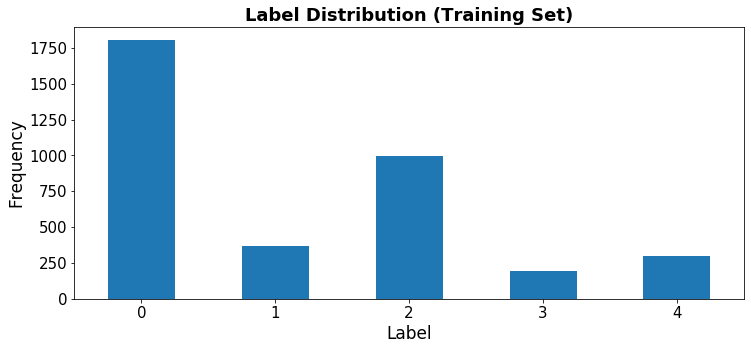

In [29]:
train_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

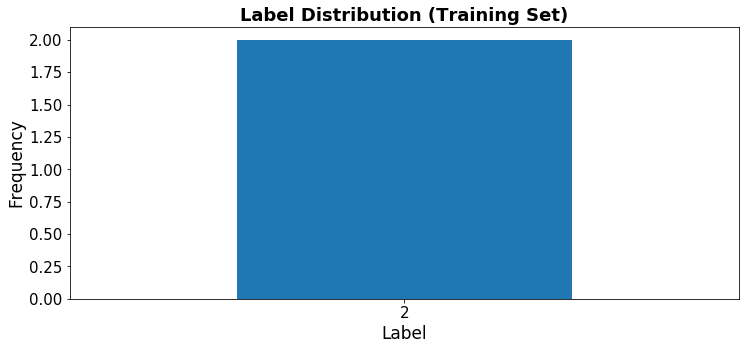

In [30]:
test_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);